In [1]:
%matplotlib inline

In [2]:
import gzip
import glob
import json

import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as ss

import matplotlib.pyplot as plt

from collections import Counter

# Read All Assessor Responses

Read the responses for each assessor and append them to an array of assessor data

In [3]:
annotators_data = []

# Read 2018 training file
in_f_path = "../data/TRECIS-CTIT-H-Training.json"
with open(in_f_path, "rb") as in_file:
    annotator_content = in_file.read().decode("latin-1") # Decode in latin-1 to deal with UTF8 errors
    trecis_training = json.loads(annotator_content)
    annotators_data.append(trecis_training)
        
# Read each assessor file
for in_f_path in glob.iglob("../data/TREC-IS-2018-Test-Labels/assr*.json"):
    with open(in_f_path, "rb") as in_file:
        annotator_content = in_file.read().decode("latin-1") # Decode in latin-1 to deal with UTF8 errors
        trecis_training = json.loads(annotator_content)
        annotators_data.append(trecis_training)

In [4]:
tweet_to_category = []
tweet_to_priority = []

for annotator in annotators_data:
    local_events = annotator["events"]
    
    for event in local_events:
        for tweet in event["tweets"]:
            # Pull out categories from the tweet dictionary (there can be several)
            for category in tweet["categories"]:
                tweet_to_category.append({
                    "tweet_id": np.int64(tweet["postID"]),
                    "category": category
                })
                
            # Pull out priority, of which there should be only one
            tweet_to_priority.append({
                "tweet_id": np.int64(tweet["postID"]),
                "priority": tweet["priority"]
            })

In [5]:
df = pd.DataFrame(tweet_to_priority)

In [6]:
# Mapping of prority labels (by assessors) into numerical values [0-1]
# We use this to calculate error against the participant priority scores
priority_mapping = {
    "Critical" : 1.0,
    "High" : 0.75,
    "Medium" : 0.5,
    "Low" : 0.25,
    "Unknown" : 0.0,
}

merged_priorities = []
for tweet_id, group in df.groupby("tweet_id"):
    priority_list = list(group["priority"])

    p_scores = [priority_mapping[p] for p in priority_list]
    
    merged_priorities.append({
        "tweet_id": tweet_id,
        "score_mean": np.mean(p_scores),
        "score_std": np.std(p_scores),
        "score_k": len(p_scores),
    })

In [7]:
priority_df = pd.DataFrame(merged_priorities)

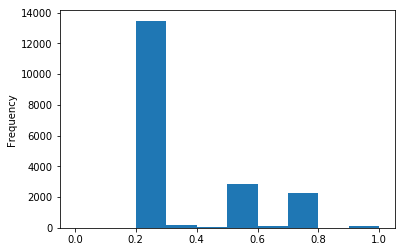

In [8]:
priority_df["score_mean"].plot.hist()

In [9]:
print("Tweets with Priority:", priority_df.shape[0])

Tweets with Priority: 19046


In [10]:
priority_df.to_csv("tweet_to_priority.csv", index=False)

In [11]:
category_df = pd.DataFrame(tweet_to_category)
print("Tweets with Category:", category_df["tweet_id"].value_counts().index.shape[0])

Tweets with Category: 19046


In [12]:
category_df.to_csv("tweet_to_category.csv", index=False)